 # CONTEGGIO OCCORRENZE PATTERN STATICI SUI VIDEO

In [1]:
import pandas as pd
import pandas as pd
from pathlib import Path

from staticpattern.counting import process_static_videos_to_csv

# Root del progetto: un livello sopra la cartella notebooks
ROOT = Path().resolve().parents[0]

# File CSV dove salvare le frequenze statiche aggregate
path_out = ROOT / "examples/data" / "frequenze_statici_video.csv"

# ---------------------------------------------------------------------
# Qui processiamo i video "spezzati" del dataset di controllo.
# Ogni video viene letto, si scartano i primi 15 frame e si contano
# i pattern statici 3×3 (512 possibili) su 3 frame successivi.
#
# Il risultato complessivo viene normalizzato e salvato in un CSV
# compatibile con `ImportData(real_counting=True)`.
# Il file di log permette di verificare eventuali errori o imprevisti.
# ---------------------------------------------------------------------

results = process_static_videos_to_csv(
    folder=r"C:\Users\braua\Documents\TesiMagistrale\DATASET_RIPULITO\VIDEO_SPEZZATI\CONTROLLO\SKETCH_0_0",
    output_csv=path_out,
    skip_frames=15,      # scarta i primi 15 frame (instabili / non significativi)
    max_frames=3,        # conta solo 3 frame per video
    log_path=ROOT / "output" / "log_statici.txt",
    verbose=0
)

# Controllo rapido del risultato
print("Video processati:", results["videos_processed"])
print("Frame totali elaborati:", results["total_frames"])
print("CSV generato in:", path_out)


Video processati: 5169
Frame totali elaborati: 15507
CSV generato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\examples\data\frequenze_statici_video.csv



---

### Generazione Sketch

1. Carica il CSV con `ImportData(TimeFilter=1, SpaceFilter=3)`.
2. Applica l’euristica con `N=50, W=0.025`.
3. Usa i pattern selezionati per generare gli sketch degli stessi video.



In [2]:
from pathlib import Path

from motionpattern.pattern_table import ImportData, apply_heuristic
from motionpattern.sketch_generator import SketchGenerator

# ------------------------------------------------------------------
# 1) Carico il file di frequenze statiche con ImportData
# ------------------------------------------------------------------

ROOT = Path().resolve().parents[0]

path_csv_statici = ROOT / "output" / "frequenze_statici_video.csv"

# TimeFilter=1 e SpaceFilter=3 perché stiamo lavorando con pattern statici 3×3
table_static = ImportData(
    path=path_csv_statici,
    real_counting=True,
    TimeFilter=1,
    SpaceFilter=3,
)

print("Tabella statica caricata.")
table_static.print_info(masked=True)

# ------------------------------------------------------------------
# 2) Applico l'euristica con N = 50 e W = 0.025
# ------------------------------------------------------------------

Max_N = 50
Max_W = 0.025

table_heur = apply_heuristic(
    df=table_static,
    Max_W=Max_W,
    Max_N=Max_N,
    inplace=False,   # creo una copia, non modifico l'originale
)

print("\nDopo euristica (pattern selezionati):")
table_heur.print_info(masked=True)

# pattern selezionati (PatternValue = interi)
patterns_value = table_heur.get_PatternsValue(masked=True)
patterns_list = list(patterns_value)

print(f"\nNumero di pattern selezionati: {len(patterns_list)}")

# ------------------------------------------------------------------
# 3) Prendo i video binarizzati e genero gli sketch
# ------------------------------------------------------------------

# Cartella dei video binarizzati
folder_videos = Path(
    r"C:\Users\braua\Documents\TesiMagistrale\DATASET_RIPULITO\VIDEO_BINARIZZATI"
)

# Cartella di output per gli sketch generati con i pattern euristici
output_sketch_dir = ROOT / "output" / "sketch_statici_heuristica"
output_sketch_dir.mkdir(parents=True, exist_ok=True)

print(f"\nGenerazione sketch in: {output_sketch_dir}")

for i, video_path in enumerate(sorted(folder_videos.glob("*.avi"))):
    print(f"[{i}] Sketch da: {video_path.name}")

    out_path = output_sketch_dir / f"sketch_heur_{video_path.name}"

    sk = SketchGenerator(
        path_in=str(video_path),
        path_out=str(out_path),
        list_patterns=patterns_list,
        TimeFilter=1,   # statici
        SpaceFilter=3,  # patch 3×3
        frame_rate=None,
        max_frame=None,  # tutti i frame
    )

    stats = sk.generate(lossless=True, verbose=0)
    # stats è un dict se hai la versione con log, oppure (ratio, frame_count) se hai la vecchia
    print(f"  -> sketch salvato in: {out_path}\n")

    # faccio solo 3 video se no non la finisce più
    if i > 3 :
        break



Tabella statica caricata.
Numero di pattern selezionati: 512
Larghezza di banda (somma p): 1.000000
Entropia totale: 2.354515
Somma EntropyRatio: 1.000000

Dopo euristica (pattern selezionati):
Numero di pattern selezionati: 33
Larghezza di banda (somma p): 0.024850
Entropia totale: 0.177062
Somma EntropyRatio: 0.075201

Numero di pattern selezionati: 33

Generazione sketch in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\sketch_statici_heuristica
[0] Sketch da: 0.avi
  -> sketch salvato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\sketch_statici_heuristica\sketch_heur_0.avi

[1] Sketch da: 1.avi
  -> sketch salvato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\sketch_statici_heuristica\sketch_heur_1.avi

[2] Sketch da: 10.avi
  -> sketch salvato in: C:\Users\braua\Documents\TesiMagistrale\repository\Pattern-Motion-Project\output\sketch_statici_heuristica\sketch_heur_10.av

In [3]:
from motionpattern.spezzetta_sketch import spezzetta_sketch
from pathlib import Path

# ==========================================================
# PATH DI INPUT/OUTPUT DA CAMBIARE IN BASE ALL’ESPERIMENTO
# ==========================================================

# Cartella base del dataset (da cambiare se il dataset è altrove)
base = Path(r"C:\Users\braua\Documents\TesiMagistrale\DATASET_RIPULITO")

# Video binarizzati completi (input)
folder_bin = base / "VIDEO_BINARIZZATI"

# Video sketch completi (input) per questo set di pattern
# Esempio: STATICI_50_0.025 è il nome scelto per l'esperimento
folder_sketch = base / "VIDEO_PATTERN_NON_OTTIMALI" / "STATICI_50_0.025"

# Cartelle di output dove salvare i video spezzettati
# (digitalizzati e sketch corrispondenti)
out_folder_bin = base / "VIDEO_SPEZZATI" / "NON_OTTIMALI" / "DIGITALIZED_50_0.025"
out_folder_sketch = base / "VIDEO_SPEZZATI" / "NON_OTTIMALI" / "SKETCH_50_0.025"

# ==========================================================
# PARAMETRI DA ADATTARE AL NOME DEI FILE E ALL’ESPERIMENTO
# ==========================================================
# bin_prefix       : prefisso dei file binarizzati originali (se esiste)
# sketch_prefix    : prefisso dei file sketch originali
# out_bin_prefix   : prefisso per i file binarizzati spezzettati in output
# out_sketch_prefix: prefisso per i file sketch spezzettati in output
# len_sketch       : lunghezza (in frame) di ogni clip spezzata
# extra            : frame extra prima/dopo il blocco centrale
# padding          : margine in frame che non viene usato (es. all'inizio/fine)
# seed             : seed per la randomizzazione delle posizioni
# ==========================================================

spezzetta_sketch(
    folder_bin=folder_bin,
    folder_sketch=folder_sketch,
    out_folder_bin=out_folder_bin,
    out_folder_sketch=out_folder_sketch,
    bin_prefix="",                     # mettere qui il prefisso dei video bin, se esiste
    sketch_prefix="STATICI_50_0.025_", # prefisso dei video sketch usati in questo esperimento
    out_bin_prefix="Digitalized_STATICI_50_0.025_",  # prefisso per i bin spezzati
    out_sketch_prefix="Sketch_STATICI_50_0.025_",    # prefisso per gli sketch spezzati
    len_sketch=3,    # numero di frame per ogni clip centrale
    extra=2,         # frame extra prima/dopo
    padding=15,      # quanti frame scartare a inizio/fine video
    seed=42,         # fissare per riproducibilità, cambiare se serve random diverso
    verbouse=0       # espressività output su terminale
)


# DISTRIBUZIONE IN FREQUENZA PATTERN IMMAGINI STATICHE DELVIVA
##  APPLICAZIONE EURISTICA 

In [12]:
import pandas as pd
from pathlib import Path

from motionpattern.pattern_table import ImportData, apply_heuristic

# Root del progetto: un livello sopra la cartella notebooks
ROOT = Path().resolve().parents[0]
DATA = ROOT / "examples" / "data"

# File di esempio con pattern statici
path_static = DATA / "pattern_statici_DelViva.csv"

# Import dei pattern statici:
# - real_counting=True  -> usa la colonna 'p' dal file
# - TimeFilter=1        -> pattern statici (nessuna dimensione temporale)
# - SpaceFilter=3       -> patch 3x3 (modifica se il file usa un'altra dimensione)
table_static = ImportData(
    path=path_static,
    real_counting=True,
    TimeFilter=1,
    SpaceFilter=3,
)

print("== Info tabella completa (tutti i pattern) ==")
table_static.print_info(masked=False)

# Parametri euristica per gli statici
Max_N = 50     # massimo 50 pattern
Max_W = 0.05   # banda massima (somma di p)

# Applica l'euristica (crea una copia, non modifica table_static)
table_static_heur = apply_heuristic(
    df=table_static,
    Max_W=Max_W,
    Max_N=Max_N,
    inplace=False,
)

print("\n== Info dopo euristica (pattern selezionati) ==")
table_static_heur.print_info(masked=True)

# Pattern selezionati (PatternValue, interi)
selected_patterns = table_static_heur.get_PatternsValue(masked=True)
print("\nPatternValue selezionati:")
print(selected_patterns)



== Info tabella completa (tutti i pattern) ==
Numero di pattern totali: 512
Larghezza di banda (somma p): 0.999993
Entropia totale: 1.527432
Somma EntropyRatio: 1.000000

== Info dopo euristica (pattern selezionati) ==
Numero di pattern selezionati: 39
Larghezza di banda (somma p): 0.048669
Entropia totale: 0.323044
Somma EntropyRatio: 0.211495

PatternValue selezionati:
Index([  2,   3,   6,   8,   9,  15,  32,  36,  38,  39,  55,  72, 127, 128,
       192, 200, 201, 217, 219, 223, 288, 294, 310, 319, 383, 384, 438, 439,
       456, 472, 475, 479, 480, 502, 503, 504, 505, 508, 509],
      dtype='int64', name='PatternValue')


## DISTRIBUZIONE IN FREQUENZA

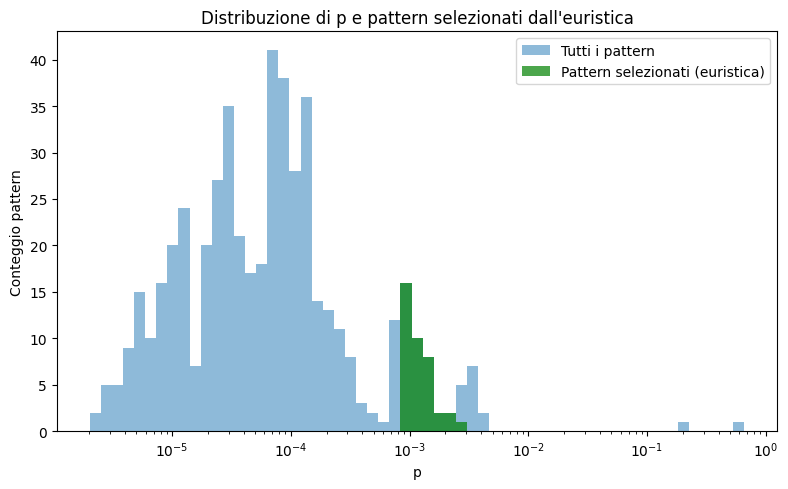

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# p di tutti i pattern (ignoro la Mask)
p_all = table_static["p"].to_numpy()

# p dei pattern selezionati dall'euristica
p_sel = table_static_heur.loc[table_static_heur["Mask"], "p"].to_numpy()



# bin logaritmici sull'asse x
bins = np.logspace(np.log10(p_all.min()), np.log10(p_all.max()), 60)

plt.figure(figsize=(8, 5), dpi = 100)

# Istogramma di tutti i pattern (grigio)
plt.hist(
    p_all[p_all > 0],
    bins=bins,
    alpha=0.5,
    label="Tutti i pattern",
)

# Istogramma dei pattern selezionati (verde)
plt.hist(
    p_sel[p_sel > 0],
    bins=bins,
    alpha=0.7,
    label="Pattern selezionati (euristica)",
    color="green",
)

plt.xscale("log")
plt.xlabel("p")
plt.ylabel("Conteggio pattern")
plt.title("Distribuzione di p e pattern selezionati dall'euristica")
plt.legend()
plt.tight_layout()
plt.show()


## CONFRONTO CON PATTERN SELEZIONATI DALLA DELVIVA
I pattern sono forniti come matrici binarie 3x3, per cui li converto nella codifica intera

In [21]:
pattern_selezionati_del_viva = [[[0, 1, 1], [0, 1, 1], [0, 0, 0]], [[1, 1, 0], [1, 1, 
     1], [0, 1, 1]], [[0, 0, 1], [0, 0, 1], [1, 1, 1]], [[0, 0, 
     0], [1, 1, 0], [1, 1, 0]], [[1, 1, 1], [0, 0, 1], [0, 0, 
     1]], [[1, 0, 0], [1, 0, 0], [1, 1, 1]], [[1, 1, 1], [1, 0, 
     0], [1, 0, 0]], [[0, 1, 0], [0, 1, 0], [0, 1, 0]], [[0, 0, 
     0], [1, 1, 0], [0, 0, 0]], [[0, 0, 0], [0, 1, 1], [0, 0, 
     0]], [[0, 0, 0], [0, 1, 1], [0, 1, 1]], [[1, 1, 1], [1, 0, 
     1], [1, 1, 1]], [[0, 0, 0], [1, 1, 1], [0, 0, 0]], [[0, 0, 
     0], [0, 1, 0], [0, 1, 0]], [[1, 1, 0], [1, 1, 0], [0, 0, 
     0]], [[0, 0, 0], [0, 1, 0], [0, 0, 0]], [[0, 1, 1], [1, 1, 
     1], [1, 1, 0]], [[0, 0, 1], [0, 0, 0], [1, 0, 0]], [[0, 0, 
     0], [0, 0, 0], [1, 0, 1]], [[1, 0, 1], [0, 0, 0], [0, 0, 
     0]], [[1, 1, 0], [1, 1, 0], [1, 0, 0]], [[0, 0, 1], [0, 1, 
     1], [0, 1, 1]], [[1, 1, 0], [1, 0, 0], [1, 0, 0]], [[1, 1, 
     1], [0, 1, 1], [0, 0, 1]], [[0, 0, 1], [0, 0, 1], [0, 1, 
     1]], [[0, 0, 0], [0, 1, 1], [1, 1, 1]], [[0, 1, 0], [0, 1, 
     0], [0, 0, 0]], [[1, 1, 1], [1, 1, 0], [1, 0, 0]], [[1, 1, 
     1], [1, 1, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 1], [0, 1, 
     1]], [[1, 0, 0], [1, 1, 0], [1, 1, 1]], [[1, 1, 0], [1, 0, 
     0], [0, 0, 0]], [[0, 0, 1], [0, 1, 1], [1, 1, 1]], [[0, 0, 
     0], [0, 0, 1], [1, 1, 1]], [[1, 1, 1], [1, 0, 0], [0, 0, 
     0]], [[0, 1, 1], [0, 1, 1], [0, 0, 1]], [[1, 1, 1], [0, 1, 
     1], [0, 0, 0]], [[0, 1, 1], [0, 0, 1], [0, 0, 0]], [[0, 0, 
     0], [1, 1, 0], [1, 1, 1]], [[1, 1, 1], [0, 1, 1], [1, 1, 
     1]], [[1, 0, 0], [1, 1, 0], [1, 1, 0]], [[1, 1, 1], [1, 1, 
     1], [1, 0, 1]], [[1, 1, 1], [0, 0, 1], [0, 0, 0]], [[1, 0, 
     1], [1, 1, 1], [1, 1, 1]], [[0, 0, 0], [1, 0, 0], [1, 1, 
     0]], [[1, 1, 1], [1, 1, 0], [1, 1, 1]], [[0, 0, 0], [1, 0, 
     0], [1, 1, 1]], [[0, 1, 1], [0, 0, 1], [0, 0, 1]], [[1, 0, 
     0], [1, 0, 0], [1, 1, 0]], [[1, 0, 0], [0, 0, 0], [1, 0, 0]]]

def encode_static_pattern(pattern_3x3):
    """
    Converte un pattern statico 3×3 (valori 0/1) in un intero.
    L'ordine è:
        riga 0, col 0  → bit più significativo
        riga 2, col 2  → bit meno significativo

    pattern_3x3 : lista 3×3 di 0/1
    ritorna : int
    """
    S = len(pattern_3x3)  # es. 3
    value = 0
    bit = S*S - 1  # per 3x3 → 8

    for r in range(S):
        for c in range(S):
            value |= (pattern_3x3[r][c] & 1) << bit
            bit -= 1

    return value


pattern_delviva_int = [encode_static_pattern(p) for p in pattern_selezionati_del_viva]

### CONFRONTO ISTOGRAMMI E INFORMAZIONE

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from motionpattern.pattern_table import ImportData, apply_heuristic

# Root del progetto: un livello sopra la cartella notebooks
ROOT = Path().resolve().parents[0]
DATA = ROOT / "examples" / "data"

# File di esempio con pattern statici
path_static = DATA / "pattern_statici_DelViva.csv"

# Import dei pattern statici:
# - real_counting=True  -> usa la colonna 'p' dal file
# - TimeFilter=1        -> pattern statici (nessuna dimensione temporale)
# - SpaceFilter=3       -> patch 3x3 (modifica se il file usa un'altra dimensione)
table_static = ImportData(
    path=path_static,
    real_counting=True,
    TimeFilter=1,
    SpaceFilter=3,
)


# 2) Seleziono nel PatternTable solo i pattern di Del Viva che sono presenti
df_delviva = table_static.loc[
    table_static.index.isin(pattern_delviva_int)
].copy()

# 3) Selezione euristica (Mask=True nella tabella euristica)
df_heur = table_static_heur.loc[
    table_static_heur["Mask"]
].copy()

# 4) Funzione di riepilogo
def _stats(df: pd.DataFrame, name: str) -> pd.Series:
    return pd.Series(
        {
            "set": name,
            "N": len(df),
            "Bandwidth (sum p)": df["p"].sum(),
            "Entropy": df["Entropy"].sum(),
            "EntropyRatio": df["EntropyRatio"].sum(),
        }
    )

# 5) Costruisco tabella confronto
stats_all      = _stats(table_static, "Tutti i pattern")
stats_heur     = _stats(df_heur, "Euristica")
stats_delviva  = _stats(df_delviva, "Del Viva (∩ tabella)")

summary = pd.concat([stats_all, stats_heur, stats_delviva], axis=1).T
display(summary)


,set,N,Bandwidth (sum p),Entropy,EntropyRatio
0,Tutti i pattern,512,0.999993,1.527432,1.0
1,Euristica,39,0.048669,0.323044,0.211495
2,Del Viva (∩ tabella),50,0.031479,0.228729,0.149748


### CONFRONTO ISTOGRAMMI

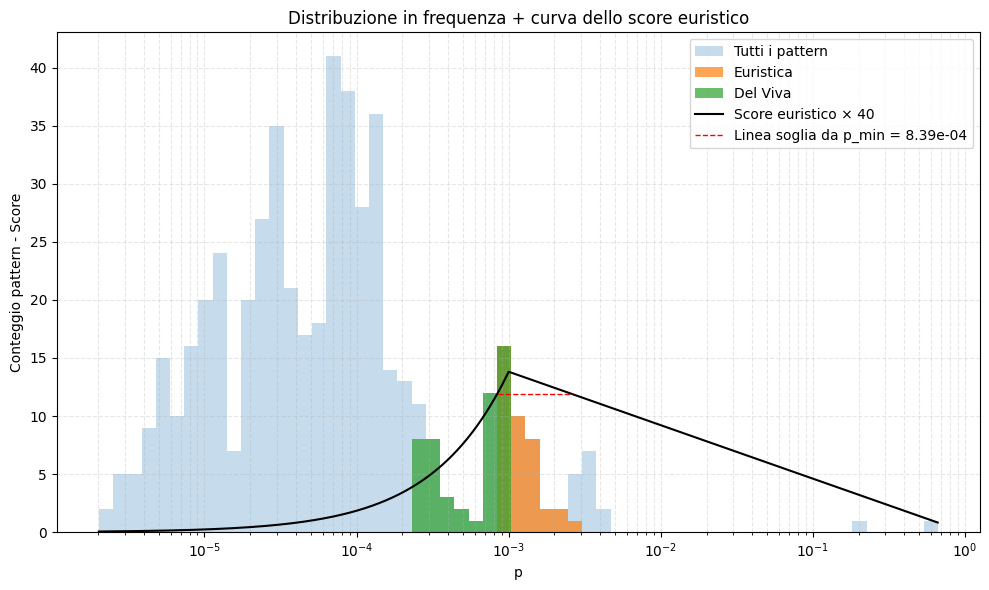

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram_with_heuristic_curve(
    table_all,
    df_heur,
    df_delviva,
    N=50,
    W=0.05,
    scale_score=1.0
):
    """
    Istogramma log delle p + curva dello score euristico + linea orizzontale
    che parte da p_min e si ferma dove la curva dello score la supera.
    """

    # --- 1) Estrazione p ---
    p_all  = table_all["p"].to_numpy()
    p_heur = df_heur["p"].to_numpy()      if len(df_heur)>0 else np.array([])
    p_del  = df_delviva["p"].to_numpy()   if len(df_delviva)>0 else np.array([])

    if len(p_heur) == 0:
        raise ValueError("df_heur non contiene pattern selezionati.")

    # solo p>0
    p_pos = p_all[p_all > 0]
    if len(p_pos) == 0:
        raise ValueError("Nessun valore di p>0, impossibile costruire l'istogramma.")

    bins = np.logspace(np.log10(p_pos.min()), np.log10(p_pos.max()), 60)

    # --- 2) Figura ---
    plt.figure(figsize=(10, 6))

    plt.hist(p_all[p_all > 0],  bins=bins, alpha=0.25, label="Tutti i pattern")
    plt.hist(p_heur[p_heur > 0], bins=bins, alpha=0.7,  label="Euristica")
    plt.hist(p_del[p_del > 0],  bins=bins, alpha=0.7,  label="Del Viva")

    # --- 3) Curva euristica  ---
    p_curve = np.logspace(np.log10(p_pos.min()), np.log10(p_pos.max()), 1000)
    entropy_term = -p_curve * np.log(p_curve)
    cost = np.maximum(1/N, p_curve/W)
    score = (entropy_term / cost) * scale_score

    plt.plot(
        p_curve,
        score,
        color="black",
        lw=1.5,
        label=f"Score euristico × {scale_score}"
    )

    # --- 4) Soglia a p_min ---
    p_min = p_heur[p_heur > 0].min()

    entropy_min = -p_min * np.log(p_min)
    cost_min     = max(1/N, p_min/W)
    score_min    = (entropy_min / cost_min) * scale_score

    # --- 5) Troncare la linea orizzontale dove la curva supera score_min ---
    # True finché score(p) <= score_min → linea segue
    mask_line = score >= score_min

    # Consideriamo solo p >= p_min
    mask_line &= (p_curve >= p_min)

    # segmenti validi per la linea rossa
    p_line  = p_curve[mask_line]
    if len(p_line) > 0:
        plt.hlines(
            y=score_min,
            xmin=p_line.min(),
            xmax=p_line.max(),
            colors="red",
            linestyles="--",
            linewidth=1,
            label=f"Linea soglia da p_min = {p_min:.2e}"
        )

    # --- 6) Settaggi ---
    plt.xscale("log")
    plt.xlabel("p")
    plt.ylabel("Conteggio pattern - Score")
    plt.title("Distribuzione in frequenza + curva dello score euristico")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()



plot_histogram_with_heuristic_curve(
    table_all=table_static,
    df_heur=df_heur,
    df_delviva=df_delviva,
    N=50,
    W=0.05,
    scale_score=40,   # ↙ puoi aumentarlo se non si vede bene
)